# Descarga Datos CMIP6

![cmip6_logo-01](cmip6_logo-01.jpg)

En este notebook vamos a ver cómo descargar datos de modelos acoplados incluidos en el proyecto de intercomparación CMIP6.
Además, en un siguiente notebook veremos su contenido, haremos un pequeño preprocesamiento, y visualizaremos datos de temperatura superficial de los mismos.  

Vamos a usar un API para descargar los datos, y xarray para visualizarlo:
1. [`Xarray`](https://docs.xarray.dev/en/stable/index.html#).

Usaremos `Xarray` como en ocasiones anteriores ya que tenemos datos en 3 o más dimensiones.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [3]:
# Este API nos permite filtrar nuestra búsqueda atendiendo a la variable, el experimento, la institución que está a cargo de la simulacion, etc
result = esgf_search(activity_id='CMIP', table_id='Omon', variable_id='tos', 
                     experiment_id='historical',
                     source_id="CNRM-ESM2-1", member_id="r1i1p1f2")
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Omon&variable_id=tos&experiment_id=historical&source_id=CNRM-ESM2-1&member_id=r1i1p1f2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


['http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/tos/gn/v20181206/tos_Omon_CNRM-ESM2-1_historical_r1i1p1f2_gn_185001-201412.nc',
 'http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/tos/gr1/v20181206/tos_Omon_CNRM-ESM2-1_historical_r1i1p1f2_gr1_185001-201412.nc',
 'http://esgf-node.ornl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/tos/gn/v20181206/tos_Omon_CNRM-ESM2-1_historical_r1i1p1f2_gn_185001-201412.nc',
 'http://esgf-node.ornl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/tos/gr1/v20181206/tos_Omon_CNRM-ESM2-1_historical_r1i1p1f2_gr1_185001-201412.nc']

In [4]:
# Como vemos hay diferentes fuentes para el mismo archivo, así que usaremos una de ellas
files_to_open = result[-1:]
# Abrimos el archivo usando la función de archivos múltiples de xarray
ds = xr.open_mfdataset(files_to_open, combine='by_coords')
ds

<xarray.Dataset> Size: 513MB
Dimensions:      (time: 1980, axis_nbounds: 2, lat: 180, lon: 360)
Coordinates:
  * time         (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-1...
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon          (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    tos          (time, lat, lon) float32 513MB dask.array<chunksize=(1980, 180, 360), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-06-10T22:12:35Z
    description:                     CMIP6 historical
    title:                           CNRM-ESM2-1 model output prepared for CM...
    activity_id:                     CMIP
    contact:                         contact.cmip@meteo.fr
    ...                              ...
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:            6.3.2
    history:                         none
    tracking_id:                     hdl:21.14100/25785211-b12e-4698-9ed3-4aa...
    DODS_EXTRA.Unlimited_Dimension:  time

In [5]:
ds.tos

<xarray.DataArray 'tos' (time: 1980, lat: 180, lon: 360)> Size: 513MB
dask.array<open_dataset-tos, shape=(1980, 180, 360), dtype=float32, chunksize=(1980, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           Sea Surface Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    description:         This may differ from "surface temperature" in region...
    history:             none
    cell_measures:       area: areacello
    _ChunkSizes:         [  1 180 360]

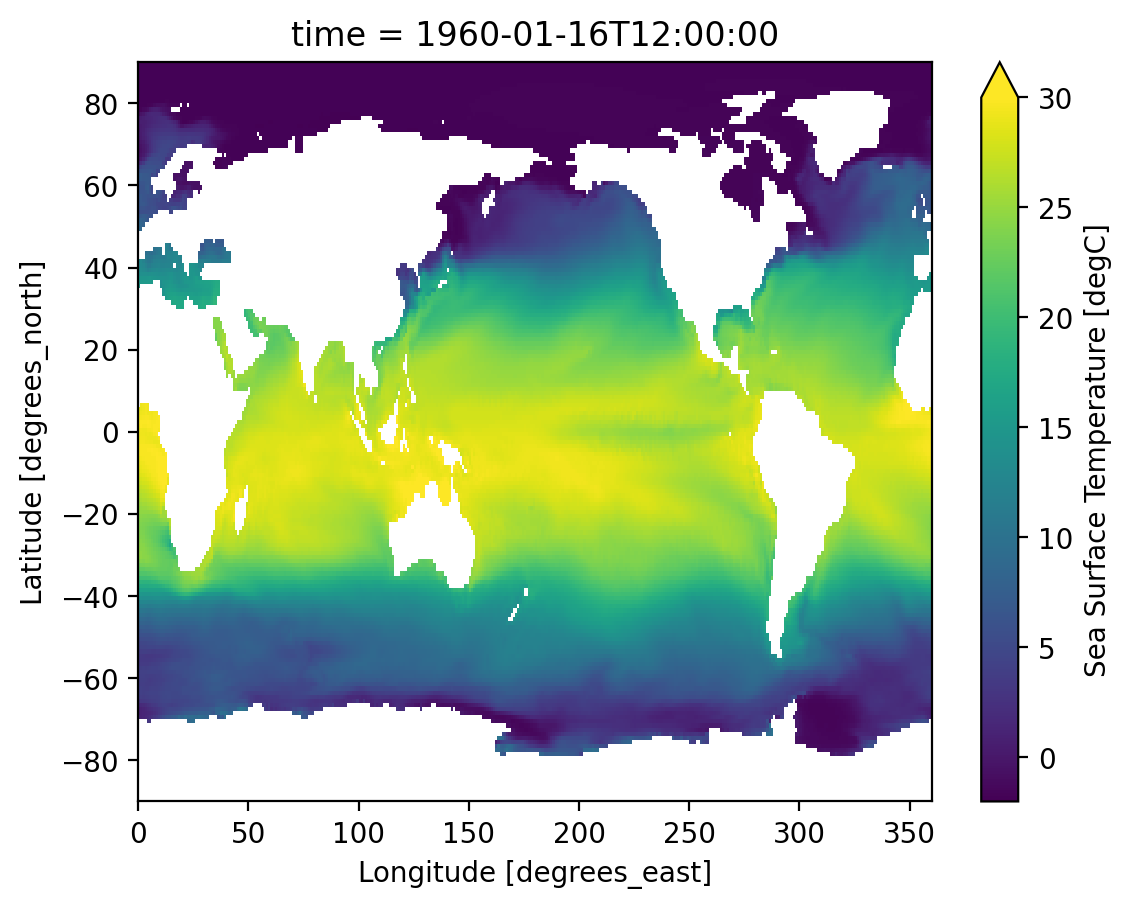

In [7]:
ds.tos.sel(time='1960-01').squeeze().plot(vmin=-2, vmax=30, cmap='viridis')

In [8]:
files_area = esgf_search(variable_id='areacello', activity_id='CMIP',
                         experiment_id='historical', source_id="CNRM-ESM2-1")
ds_area = xr.open_dataset(files_area[0])
ds_area

https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacello&activity_id=CMIP&experiment_id=historical&source_id=CNRM-ESM2-1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacello&activity_id=CMIP&experiment_id=historical&source_id=CNRM-ESM2-1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacello&activity_id=CMIP&experiment_id=historical&source_id=CNRM-ESM2-1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacello&activity_id=CMIP&experiment_id=historical&source_id=CNRM-ESM2-1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30


<xarray.Dataset> Size: 9MB
Dimensions:     (y: 294, x: 362, nvertex: 4)
Coordinates:
    lat         (y, x) float64 851kB ...
    lon         (y, x) float64 851kB ...
Dimensions without coordinates: y, x, nvertex
Data variables:
    bounds_lon  (y, x, nvertex) float64 3MB ...
    bounds_lat  (y, x, nvertex) float64 3MB ...
    areacello   (y, x) float32 426kB ...
Attributes: (12/54)
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2019-09-04T09:16:06Z
    description:                     CMIP6 historical
    title:                           CNRM-ESM2-1 model output prepared for CM...
    activity_id:                     CMIP
    contact:                         contact.cmip@meteo.fr
    ...                              ...
    parent_variant_label:            r1i1p1f2
    history:                         none
    tracking_id:                     hdl:21.14100/ab847703-8cbe-4af7-9d19-2fb...
    DODS_EXTRA.Unlimited_Dimension:  time
    EXTRA_DIMENSION.axis_nbounds:    2
    EXTRA_DIMENSION.time:            0

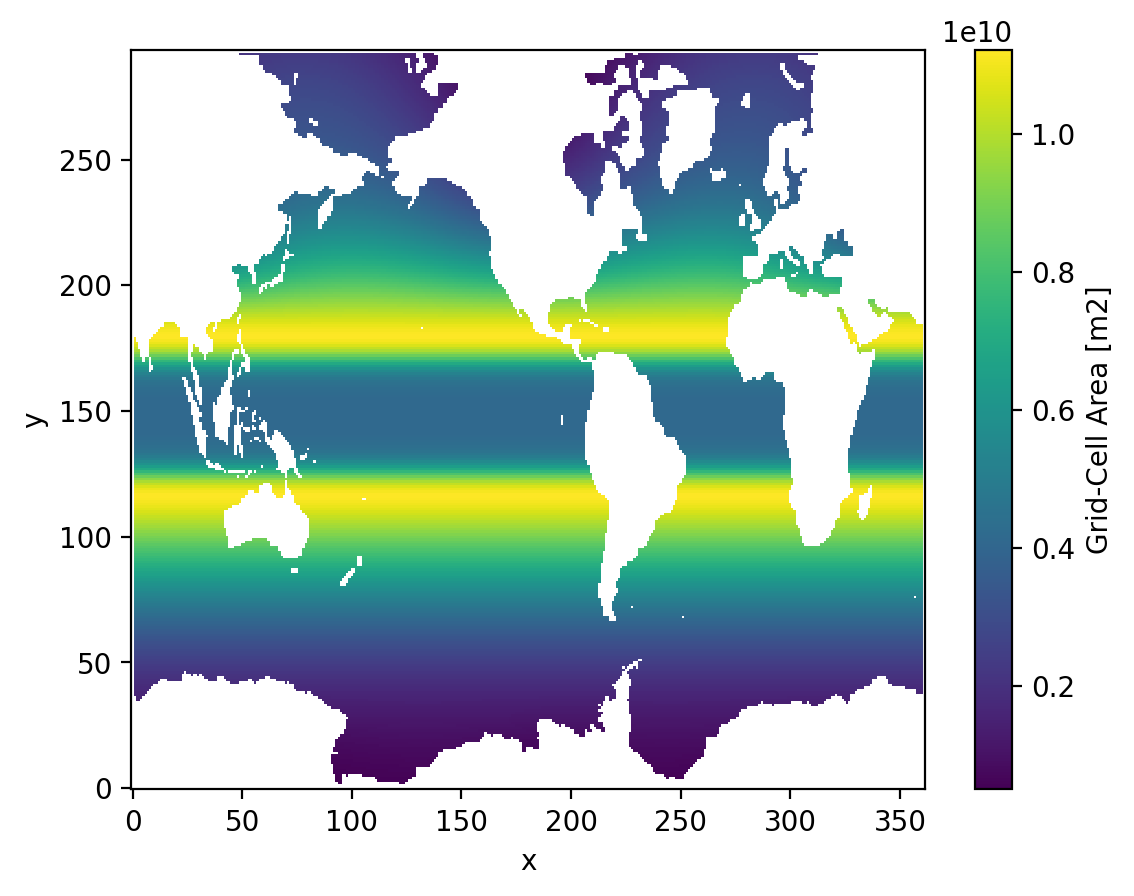

In [9]:
ds_area.areacello.squeeze().plot()